In [5]:
# === 02ByDealValuation breakdown by entry xEBITDA (terciles) ===
from pathlib import Path
import pandas as pd
import numpy as np

# ---- helper ----
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

# ---- paths ----
TARGET_CSV = (find_upwards(Path("ValueCreation")) / "Data" / "working.csv")
OUT_DIR    = (find_upwards(Path("ValueCreation")) / "ValueCreationBreakdown" / "02ByDealValuation")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV    = OUT_DIR / "deal_valuation.csv"

# ---- load + guards ----
df = pd.read_csv(TARGET_CSV, dtype={"id": str, "deal_id": str})
assert df.groupby("deal_id")["id"].nunique().eq(2).all(), "Expected exactly 2 rows per deal_id."



# ---- build entry xEBITDA per deal ----
num = lambda s: pd.to_numeric(s, errors="coerce")

# rank within deal: 1 = entry (earliest reference_date)
df["_rank"] = df.groupby("deal_id")["reference_date"].transform(
    lambda s: pd.to_datetime(s, errors="coerce")
).groupby(df["deal_id"]).rank(method="first", ascending=True)

entry = (
    df.loc[df["_rank"] == 1, ["deal_id", "xebitda"]]
      .assign(entry_xebitda=num(df.loc[df["_rank"] == 1, "xebitda"]).values)
      .drop(columns=["xebitda"])
)

# drop deals with missing entry xEBITDA (cannot be bucketed)
entry_clean = entry.dropna(subset=["entry_xebitda"]).copy()

# ---- deterministic ordering to handle ties ----
entry_clean = entry_clean.sort_values(["entry_xebitda", "deal_id"], ascending=[True, True]).reset_index(drop=True)

# ---- assign terciles with near-equal counts (rank-based) ----
n = len(entry_clean)
if n == 0:
    raise ValueError("No deals with valid entry_xebitda to bucket.")

base, rem = divmod(n, 3)
sizes = [base, base, base]
for i in range(rem):              # distribute remainder to the highest terciles (High, then Mid)
    sizes[2 - i] += 1

# naming change only
labels = np.array(
    ["Low"] * sizes[0] +
    ["Mid"] * sizes[1] +
    ["High"] * sizes[2]
)
entry_clean["tercile"] = labels

# ---- attach tercile to all rows of each deal ----
bucket_map  = entry_clean.set_index("deal_id")["tercile"].to_dict()
xebitda_map = entry_clean.set_index("deal_id")["entry_xebitda"].to_dict()

out = df.copy()
out["entry_xebitda"]    = out["deal_id"].map(xebitda_map)
out["valuation_bucket"] = out["deal_id"].map(bucket_map)

# persist
out.to_csv(OUT_CSV, index=False)

# ---- KPIs for entry xEBITDA terciles (Low/Mid/High) ----
import pandas as pd

def bucket_kpis(frame):
    """Compute KPIs for a tercile subset. Returns plain dict of scalars/strings."""
    if frame.empty:
        return {
            "count": 0, "min": "—", "p10": "—", "q1": "—", "median": "—",
            "mean": "—", "q3": "—", "p90": "—", "max": "—", "range": "—",
            "std": "—", "iqr": "—"
        }
    x = pd.to_numeric(frame["entry_xebitda"], errors="coerce").dropna().to_numpy()
    if x.size == 0:
        return {
            "count": 0, "min": "—", "p10": "—", "q1": "—", "median": "—",
            "mean": "—", "q3": "—", "p90": "—", "max": "—", "range": "—",
            "std": "—", "iqr": "—"
        }
    q = np.quantile
    return {
        "count": int(x.size),
        "min": float(np.min(x)),
        "p10": float(q(x, 0.10)),
        "q1": float(q(x, 0.25)),
        "median": float(q(x, 0.50)),
        "mean": float(np.mean(x)),
        "q3": float(q(x, 0.75)),
        "p90": float(q(x, 0.90)),
        "max": float(np.max(x)),
        "range": float(np.max(x) - np.min(x)),
        "std": float(np.std(x, ddof=1)) if x.size > 1 else float("nan"),
        "iqr": float(q(x, 0.75) - q(x, 0.25)),
    }

# Order and labels
tercile_order = ["Low", "Mid", "High"]
label_map = {"Low": "Low xEBITDA", "Mid": "Mid xEBITDA", "High": "High xEBITDA"}

# Compute KPIs per tercile
kpis = {}
for b in tercile_order:
    sub = entry_clean.loc[entry_clean["tercile"] == b]
    kpis[b] = bucket_kpis(sub)

# Empirical cutoffs implied by the assignment (based on observed maxima in Low/Mid)
low_max = pd.to_numeric(entry_clean.loc[entry_clean["tercile"]=="Low","entry_xebitda"], errors="coerce").max()
mid_max = pd.to_numeric(entry_clean.loc[entry_clean["tercile"]=="Mid","entry_xebitda"], errors="coerce").max()

print(f"Wrote: {OUT_CSV}")
print("Deal counts per tercile:", {k: v["count"] for k, v in kpis.items()})
for b in tercile_order:
    s = kpis[b]
    if s["count"] == 0:
        print(f"{label_map[b]} — n=0")
        continue
    print(
        f"{label_map[b]} — n={s['count']}, "
        f"min={s['min']:.2f}, p10={s['p10']:.2f}, Q1={s['q1']:.2f}, "
        f"median={s['median']:.2f}, mean={s['mean']:.2f}, Q3={s['q3']:.2f}, p90={s['p90']:.2f}, "
        f"max={s['max']:.2f}, range={s['range']:.2f}, std={s['std']:.2f}, IQR={s['iqr']:.2f}"
    )

# Report the realized tercile thresholds from the actual bucketing
if pd.notna(low_max) and pd.notna(mid_max):
    print(
        "Realized tercile cutoffs (by assignment): "
        f"Low ≤ {low_max:.2f}; Mid ({low_max:.2f}, {mid_max:.2f}]; High > {mid_max:.2f}"
    )
else:
    print("Realized tercile cutoffs: unavailable (insufficient data).")


Wrote: /Users/michael/Library/Mobile Documents/com~apple~CloudDocs/Studium TUM/Master Management and Technology/06 Master Thesis/00 Thesis/05Code/ValueCreation/ValueCreationBreakdown/02ByDealValuation/deal_valuation.csv
Deal counts per tercile: {'Low': 114, 'Mid': 115, 'High': 115}
Low xEBITDA — n=114, min=2.00, p10=3.98, Q1=5.05, median=6.31, mean=6.15, Q3=7.37, p90=8.12, max=8.33, range=6.33, std=1.55, IQR=2.32
Mid xEBITDA — n=115, min=8.33, p10=8.65, Q1=9.08, median=10.78, mean=11.04, Q3=12.39, p90=13.86, max=15.04, range=6.71, std=1.99, IQR=3.31
High xEBITDA — n=115, min=15.12, p10=15.99, Q1=17.82, median=21.95, mean=26.75, Q3=28.06, p90=37.32, max=129.04, range=113.92, std=16.77, IQR=10.24
Realized tercile cutoffs (by assignment): Low ≤ 8.33; Mid (8.33, 15.04]; High > 15.04


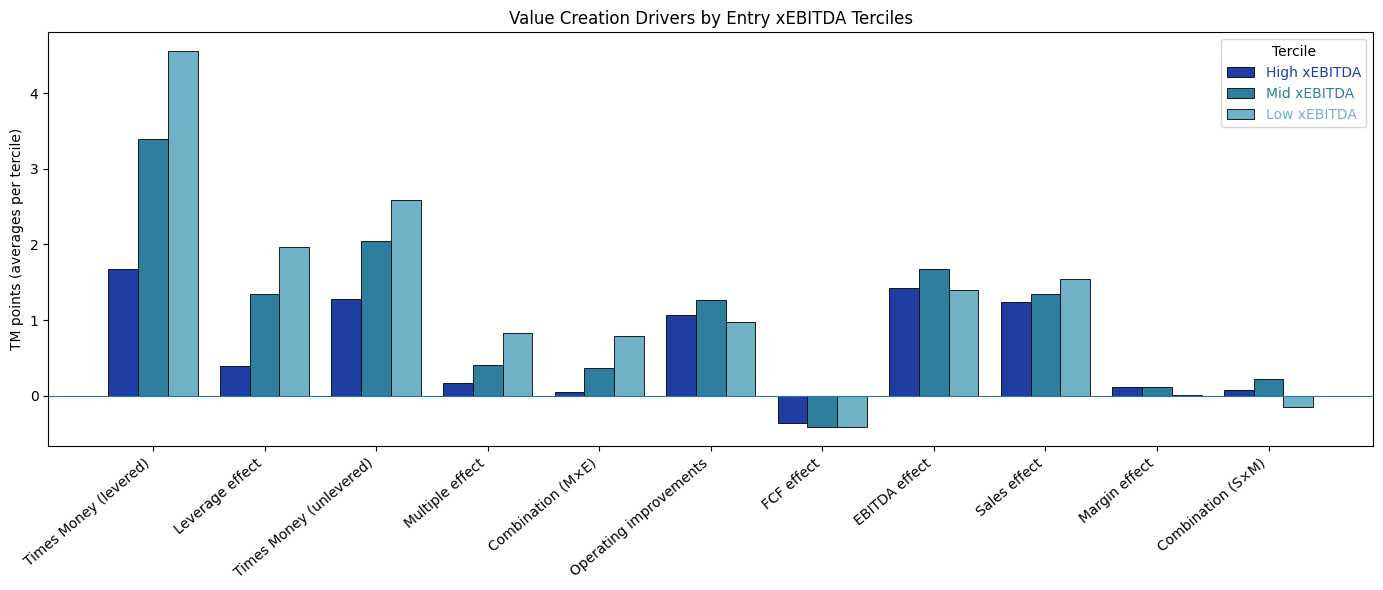

Deal counts per tercile: {'High': 115, 'Mid': 115, 'Low': 114}

TM-point averages per component × tercile:
valuation_bucket          High    Mid    Low
Times Money (levered)    1.678  3.388  4.557
Leverage effect          0.399  1.343  1.963
Times Money (unlevered)  1.279  2.046  2.594
Multiple effect          0.167  0.403  0.827
Combination (M×E)        0.048  0.372  0.786
Operating improvements   1.064  1.271  0.981
FCF effect              -0.361 -0.410 -0.419
EBITDA effect            1.426  1.681  1.400
Sales effect             1.237  1.343  1.539
Margin effect            0.111  0.119  0.005
Combination (S×M)        0.078  0.219 -0.144
{'panelB_eps': 0.001, 'dropped_near_zero_TM_per_bucket': {'High': 0, 'Mid': 0, 'Low': 0}, 'sum_TM_of_kept_deals_per_bucket': {'High': 192.97764320011444, 'Mid': 389.66953758496675, 'Low': 519.4426796411173}}


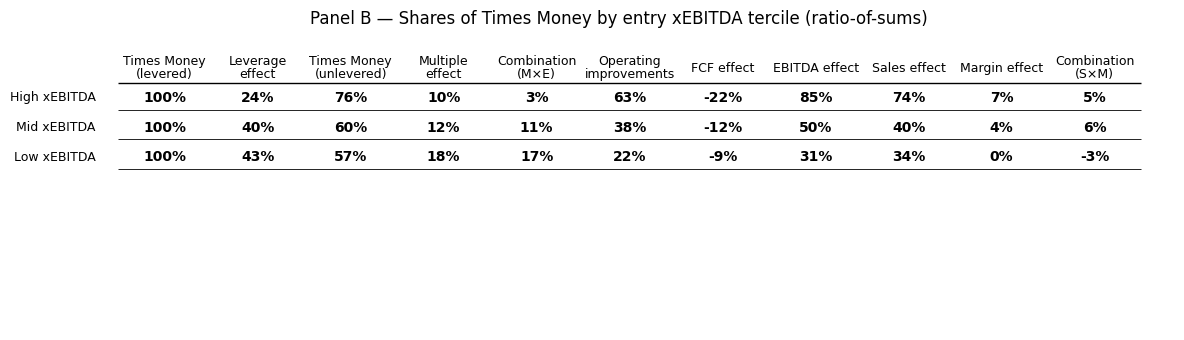

In [6]:
# === Tercile Bridge — Clustered Bars per entry xEBITDA bucket ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# ---------- paths ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

BASE       = find_upwards(Path("ValueCreation"))
WORK_CSV   = (BASE / "Data" / "working.csv")
BUCKET_CSV = (BASE / "ValueCreationBreakdown" / "02ByDealValuation" / "deal_valuation.csv")

# ---------- load ----------
work   = pd.read_csv(WORK_CSV, dtype={"deal_id": str})
bucket = pd.read_csv(BUCKET_CSV, dtype={"deal_id": str})

# ---------- deal-view (1 row per deal) + join terciles ----------
NUMERIC_COLS = [
    "times_money","leverage_effect","tm_unlevered",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]
need = ["deal_id","valuation_bucket"] + NUMERIC_COLS

# After reading `work`
for c in NUMERIC_COLS:
    work[c] = pd.to_numeric(work[c], errors="coerce")

# Ensure both rows per deal have identical values for deal-level metrics
chk = work.groupby("deal_id")[NUMERIC_COLS].nunique(dropna=False)
bad = chk[(chk > 1).any(axis=1)]
assert bad.empty, f"Deal-level metrics vary within deal for {len(bad)} deals."

# collapse metrics per deal (take first by construction)
deal_metrics = work.groupby("deal_id", as_index=False)[NUMERIC_COLS].first()
deal_buckets = bucket.groupby("deal_id", as_index=False)[["valuation_bucket"]].first()
deal = deal_metrics.merge(deal_buckets, on="deal_id", how="left")[need]

# keep only labeled terciles (new names)
deal = deal[deal["valuation_bucket"].isin(["High","Mid","Low"])].copy()

# ---------- per-bucket means (TM points) ----------
grp = deal.groupby("valuation_bucket")

means = pd.DataFrame({
    "Times Money (levered)"  : grp["times_money"].mean(),
    "Leverage effect"        : grp["leverage_effect"].mean(),
    "Times Money (unlevered)": grp["tm_unlevered"].mean(),
    "Multiple effect"        : grp["tmu_contrib_multiple_effect"].mean(),
    "Combination (M×E)"      : grp["tmu_contrib_multiple_ebitda_combination_effect"].mean(),
    # Operating improvements on TMU scale = FCF + EBITDA
    "Operating improvements" : grp["tmu_contrib_fcf_effect"].mean() + grp["tmu_contrib_ebitda_effect"].mean(),
    "FCF effect"             : grp["tmu_contrib_fcf_effect"].mean(),
    "EBITDA effect"          : grp["tmu_contrib_ebitda_effect"].mean(),
    "Sales effect"           : grp["tmu_contrib_sales_effect"].mean(),
    "Margin effect"          : grp["tmu_contrib_margin_effect"].mean(),
    "Combination (S×M)"      : grp["tmu_contrib_sales_margin_combination_effect"].mean(),
}).T  # rows = components, cols = buckets

# enforce desired bucket order (columns) and component order (rows)
bucket_order = ["High","Mid","Low"]  # mirrors previous display order (top, mid, bottom)
means = means.reindex(columns=bucket_order)

component_order = [
    "Times Money (levered)",
    "Leverage effect",
    "Times Money (unlevered)",
    "Multiple effect",
    "Combination (M×E)",
    "Operating improvements",
    "FCF effect",
    "EBITDA effect",
    "Sales effect",
    "Margin effect",
    "Combination (S×M)",
]
means = means.reindex(component_order)

PALETTE = {
    "High": "#1f3ea3",  # blue (MAIN_COLOR)
    "Mid":  "#2d7f9d",  # teal/green (STEP_COLOR)
    "Low":  "#6fb1c6",  # lighter shade
}

# ---------- plot: clustered bars (one component group, 3 bars = terciles) ----------
fig, ax = plt.subplots(figsize=(14, 6))

n_comp   = len(means.index)
n_bucket = len(means.columns)
x        = np.arange(n_comp)
width    = 0.8 / n_bucket

for i, b in enumerate(means.columns):
    ax.bar(
        x + (i - (n_bucket-1)/2) * width,
        means[b].to_numpy(),
        width=width,
        label=f"{b} xEBITDA",
        color=PALETTE[b],        # ← add
        edgecolor="black",
        linewidth=0.6
    )

ax.set_xticks(x)
ax.set_xticklabels(means.index, rotation=40, ha="right")
ax.axhline(0, linewidth=0.8)
ax.set_ylabel("TM points (averages per tercile)")
ax.set_title("Value Creation Drivers by Entry xEBITDA Terciles")
ax.legend(title="Tercile")
leg = ax.legend(title="Tercile")
for i, txt in enumerate(leg.get_texts()):
    bucket = means.columns[i]           # "High","Mid","Low" in plotted order
    txt.set_color(PALETTE[bucket])

fig.tight_layout()
plt.show()

# ---------- print & persist table of averages ----------
counts = deal.groupby("valuation_bucket")["deal_id"].nunique().reindex(bucket_order)
print("Deal counts per tercile:", counts.to_dict())

print("\nTM-point averages per component × tercile:")
print(means.round(3).to_string(float_format=lambda x: f"{x:.3f}"))

# === Panel B — table-style visualization (shares of Times Money) by xEBITDA tercile ===

# --- ratio-of-sums per tercile (shares in %) ---
cols_needed = [
    "times_money","leverage_effect",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]
eps = 1e-3
grp = deal.groupby("valuation_bucket")
S = grp[cols_needed].sum().reindex(bucket_order).astype(float)

dropped_share = {}
kept_tm_sum   = {}
for b in bucket_order:
    tm_b = pd.to_numeric(deal.loc[deal["valuation_bucket"]==b, "times_money"], errors="coerce")
    dropped_share[b] = int((tm_b.abs() <= eps).sum())
    kept_tm_sum[b]   = float(tm_b[tm_b.abs() > eps].sum())

print({"panelB_eps": eps,
       "dropped_near_zero_TM_per_bucket": dropped_share,
       "sum_TM_of_kept_deals_per_bucket": kept_tm_sum})

den = S["times_money"].astype(float)
assert np.all(np.abs(den.values) > eps), "Zero total Times Money in at least one tercile."

def pct(col): return (S[col] / den) * 100.0

panelB = pd.DataFrame(index=bucket_order, columns=component_order, dtype=float)
panelB.loc[:, "Times Money (levered)"]   = 100.0
panelB.loc[:, "Leverage effect"]         = pct("leverage_effect")
panelB.loc[:, "Multiple effect"]         = pct("tmu_contrib_multiple_effect")
panelB.loc[:, "Combination (M×E)"]       = pct("tmu_contrib_multiple_ebitda_combination_effect")
panelB.loc[:, "FCF effect"]              = pct("tmu_contrib_fcf_effect")
panelB.loc[:, "EBITDA effect"]           = pct("tmu_contrib_ebitda_effect")
panelB.loc[:, "Sales effect"]            = pct("tmu_contrib_sales_effect")
panelB.loc[:, "Margin effect"]           = pct("tmu_contrib_margin_effect")
panelB.loc[:, "Combination (S×M)"]       = pct("tmu_contrib_sales_margin_combination_effect")
panelB.loc[:, "Operating improvements"]  = panelB["FCF effect"] + panelB["EBITDA effect"]
panelB.loc[:, "Times Money (unlevered)"] = (
    panelB["Multiple effect"] + panelB["Combination (M×E)"] + panelB["Operating improvements"]
)

# --- table-like figure with headers and three value rows (High/Mid/Low) ---
headers = component_order
rows    = bucket_order

n_cols = len(headers)
n_rows = len(rows)
fig_h  = 3.0 + (n_rows-1) * 0.25
fig, ax = plt.subplots(figsize=(12, fig_h))
ax.set_axis_off()

left_margin, right_margin = 0.05, 0.97
xs = left_margin + (np.arange(n_cols) + 0.5) * (right_margin - left_margin) / n_cols

y_header = 0.88 #0.88
row_start = 0.78 #0.66
row_gap   = 0.1 #0.16
ys = [row_start - i*row_gap for i in range(n_rows)]

wrap_w = 14
for x_pos, hdr in zip(xs, headers):
    ax.text(x_pos, y_header, textwrap.fill(hdr, width=wrap_w),
            ha="center", va="center", fontsize=9, linespacing=1.05, transform=ax.transAxes)

row_label_x = left_margin - 0.02
row_names = {"High": "High xEBITDA", "Mid": "Mid xEBITDA", "Low": "Low xEBITDA"}
for y_pos, r in zip(ys, rows):
    ax.text(row_label_x, y_pos, row_names[r],
            ha="right", va="center", fontsize=9, transform=ax.transAxes)

for y_pos, r in zip(ys, rows):
    for x_pos, hdr in zip(xs, headers):
        val = panelB.loc[r, hdr]
        ax.text(x_pos, y_pos, f"{val:.0f}%", ha="center", va="center",
                fontsize=10, fontweight="bold", transform=ax.transAxes)

sep_top = (y_header + ys[0]) / 2
ax.hlines([sep_top], xmin=left_margin, xmax=right_margin,
          colors="black", linewidth=1.0, transform=ax.transAxes)
for y_pos in ys:
    ax.hlines([y_pos - row_gap/2 + 0.01], xmin=left_margin, xmax=right_margin,
              colors="black", linewidth=0.6, transform=ax.transAxes)

ax.set_title("Panel B — Shares of Times Money by entry xEBITDA tercile (ratio-of-sums)", pad=6)
fig.tight_layout()
plt.show()
